# Assignement 2: Automatic diagnosis in medical images

Install the library `medmnist` in our virtual machine. (Only needed at the beggining of each session).

In [1]:
!pip install -q medmnist

## Load necessary libraries and packages


In [49]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.optim import lr_scheduler

import medmnist
from medmnist import INFO
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

print("Pytorch version:", torch.__version__)
print("GPU available:", torch.cuda.is_available())
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

Pytorch version: 1.11.0+cu113
GPU available: True
MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


## Transforms
We will implement the same data preprocessing for both of the datasets we will use so that the different models are compatible with each other.
This is based on the fact that the images of the datasets we will use have same dimensions. (28$\times$28$\times$3)

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5]),
        transforms.RandomHorizontalFlip()
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5])
    ]),
}

# 1. Colon Pathology Datatset

## Load the Colon Pathology dataset 

In [4]:
# The object medmnist.INFO manages all the medmnist datasets. With the key 'pathmnist' (we found it in the documentation) we select the Colon Pathology Dataset
path_info = INFO['pathmnist']
path_task = path_info['task']
path_channels = path_info['n_channels']
path_classes = len(path_info['label'])

print ("The images of the dataset have", path_channels, "channels. The type of the problem is", path_task, "classification with", path_classes, "classes.")

The images of the dataset have 3 channels. The type of the problem is multi-class classification with 9 classes.


In [5]:
INFO['pathmnist'].values()

dict_values(['PathMNIST', 'The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.', 'https://zenodo.org/record/6496656/files/pathmnist.npz?download=1', 'a8b06965200029087d5bd730944a56c1', 'multi-class', {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}, 3, {'train': 89996, 'val': 1000

In [6]:
(path_info).keys()

dict_keys(['python_class', 'description', 'url', 'MD5', 'task', 'label', 'n_channels', 'n_samples', 'license'])

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
---------------------------------------------------------------------
Διαθέσιμες πληροφορίες για το dataset:
dict_keys(['python_class', 'description', 'url', 'MD5', 'task', 'label', 'n_channels', 'n_samples', 'license'])
Περιγραφή dataset:
The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. T

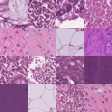

In [50]:
# The field 'python_class' of info returns a python class which functions as a pytorch dataset, so that we pass it to the dataloader
Path_DataClass = getattr(medmnist, path_info['python_class'])

# Data download & load
path_train_dataset = Path_DataClass(split='train', transform=data_transforms['train'], download=True)
path_val_dataset = Path_DataClass(split='val', transform=data_transforms['test'], download=True)
path_test_dataset = Path_DataClass(split='test', transform=data_transforms['test'], download=True)

#The .info is a dictionary with explanatory information about the dataset
print("---------------------------------------------------------------------")
print("Διαθέσιμες πληροφορίες για το dataset:")
print(path_train_dataset.info.keys())
print("Περιγραφή dataset:")
print(path_train_dataset.info['description'])
print("Ερμηνεία labels:")
print(path_train_dataset.info['label'])

BATCH_SIZE = 128

# encapsulate data into dataloader form
path_train_loader = data.DataLoader(dataset=path_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
path_val_loader = data.DataLoader(dataset=path_val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
path_test_loader = data.DataLoader(dataset=path_test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

print("Δείγμα εικόνων του Colon Pathology dataset:")
path_train_dataset.montage(length=4)

In [8]:
Path_DataClass

medmnist.dataset.PathMNIST

In [9]:
classes = tuple(path_train_dataset.info['label'].values())

In [10]:
classes

('adipose',
 'background',
 'debris',
 'lymphocytes',
 'mucus',
 'smooth muscle',
 'normal colon mucosa',
 'cancer-associated stroma',
 'colorectal adenocarcinoma epithelium')

## Build the model

We will build a model that gets as input 3-channel images and returns 9 classes specifically for the PathMNIST. Every change we will make (i.e. on the number of classes/outputs) will take place after we create an instance of the same model. 

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 3 * 3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 9))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net()
# Move model weights to GPU
# Alternatively model.to(device)
if torch.cuda.is_available():
    model.cuda()
    
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)


## Create a testing function
which will be used to track accuracy improvents while training and validating through the epochs and also finally for testing.

In [12]:
def test_loop(dataloader, model):

  # Create list to store every batch's accuracy
  tot_acc=[]

  # again no gradients needed
  with torch.no_grad():
      for i,data in enumerate(dataloader):
          # images, labels = data
          images, labels = data[0].to(device), data[1].to(device)
          outputs = model(images)
          _, predictions = torch.max(outputs, 1)
          
          # Move both tensors to CPU in order to calculate accuracy
          tot_acc.append(accuracy_score(labels.cpu(),predictions.cpu()))

  # Calculate the mean accu
  return np.mean(tot_acc)

## Training (with GPU)

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [14]:
print("length of path_train_loader = ",len(path_train_loader))

length of path_train_loader =  704


In [15]:
# Save the accuracy of every epoch
train_acc=[]
validation_acc=[]

# 9 Epochs
for epoch in range(9):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(path_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        labels = labels.squeeze().long()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0
    
    print(f'Learning rate used in epoch {epoch+1} =', scheduler.get_last_lr())
    scheduler.step()
    train_acc.append(test_loop(path_train_loader,model))
    validation_acc.append(test_loop(path_val_loader,model))
    print("Accuracy in train dataset = ", train_acc[epoch])
    print("Accuracy in validation dataset = ", validation_acc[epoch])

print('Finished Training')

[1,   100] loss: 1.085
[1,   200] loss: 0.708
[1,   300] loss: 0.567
[1,   400] loss: 0.507
[1,   500] loss: 0.437
[1,   600] loss: 0.405
[1,   700] loss: 0.379
Learning rate used in epoch 1 = [0.005]
Accuracy in train dataset =  0.8640876538825758
Accuracy in validation dataset =  0.8655664062499999
[2,   100] loss: 0.353
[2,   200] loss: 0.330
[2,   300] loss: 0.306
[2,   400] loss: 0.289
[2,   500] loss: 0.279
[2,   600] loss: 0.264
[2,   700] loss: 0.260
Learning rate used in epoch 2 = [0.005]
Accuracy in train dataset =  0.896710020123106
Accuracy in validation dataset =  0.8949414062500001
[3,   100] loss: 0.250
[3,   200] loss: 0.240
[3,   300] loss: 0.228
[3,   400] loss: 0.219
[3,   500] loss: 0.222
[3,   600] loss: 0.200
[3,   700] loss: 0.191
Learning rate used in epoch 3 = [0.005]
Accuracy in train dataset =  0.9244754675662878
Accuracy in validation dataset =  0.9257617187499999
[4,   100] loss: 0.172
[4,   200] loss: 0.156
[4,   300] loss: 0.159
[4,   400] loss: 0.162
[4,

## Save trained model's weights on drive

In [16]:
FILENAME = './pathmnist_model.pth'
torch.save(model.state_dict(), 'pathmnist_model.pth')

## A small test

The ground truth

GroundTruth:
lymphocytes
smooth muscle
background
background
debris
adipose


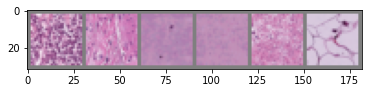

In [17]:
import matplotlib.pyplot as plt
import torchvision

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(path_train_loader)
images, labels = dataiter.next()

#print labels 
print('GroundTruth:')
for j in range(6):
     print(''.join(classes[labels[j]]))
   
# print images
imshow(torchvision.utils.make_grid(images[0:6]))

The predictions

Predicted: 
lymphocytes
smooth muscle
background
background
debris
adipose


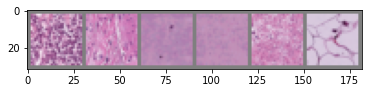

In [18]:
# push images to GPU
images = images.to(device)

outputs = model(images)

# We keep the class with the maximum output for each image
# torch.max returns a tuple whose second field is the position of the maximum
_, predicted = torch.max(outputs, 1)

print('Predicted: ')
for j in range(6):
     print(''.join(classes[predicted[j]]))

imshow(torchvision.utils.make_grid(images[0:6]))

## Testing (with GPU)

Since the classes are balanced, accuracy will be used, otherwise F-measure would be a better option.

In [19]:
test_acc = test_loop(path_test_loader, model)
print("Model's accuracy in Colon Pathology test dataset = ", test_acc)

Model's accuracy in Colon Pathology test dataset =  0.88128591954023


## Plot accuracy

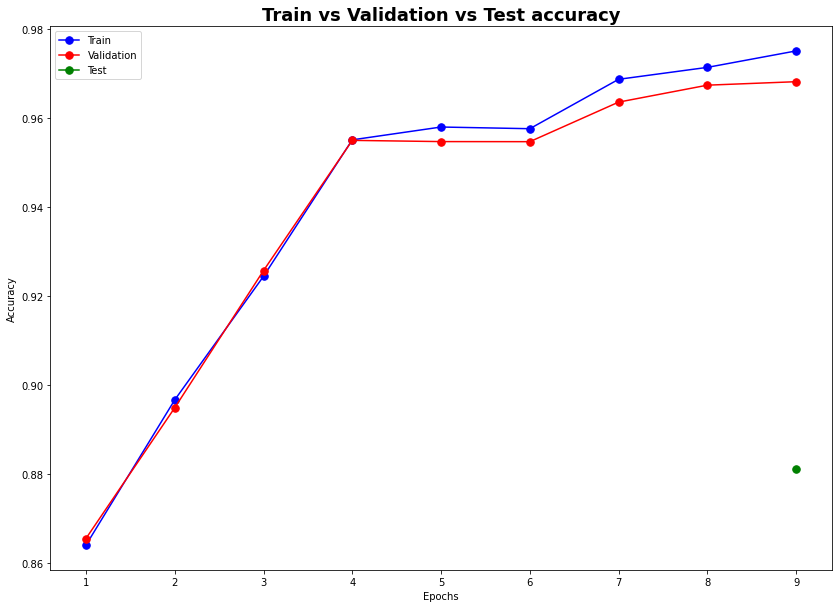

In [20]:
plt.figure(figsize=(14,10))

plt.title('Train vs Validation vs Test accuracy', fontdict={'fontweight':'bold', 'fontsize': 18})

epochs=[i for i in range(1,10)]

plt.plot(epochs, train_acc, 'b.-', label='Train', markersize=15)
plt.plot(epochs, validation_acc, 'r.-', label='Validation', markersize=15)
plt.plot(9, test_acc, 'g.-', label='Test', markersize=15)

plt.xticks(epochs[:])

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

plt.show()

Test accuracy is significantly lower than train accuracy so we conclude that the model suffers from overfitting.

## Test accuracy for each class

In [21]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in path_test_loader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    #acc = accuracy_score(y_true, y_pred)
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: adipose is 97.8 %
Accuracy for class: background is 100.0 %
Accuracy for class: debris is 79.9 %
Accuracy for class: lymphocytes is 77.6 %
Accuracy for class: mucus is 90.9 %
Accuracy for class: smooth muscle is 83.8 %
Accuracy for class: normal colon mucosa is 79.5 %
Accuracy for class: cancer-associated stroma is 57.7 %
Accuracy for class: colorectal adenocarcinoma epithelium is 91.8 %


## Check if GPU was utilised
If the calculations were performed on the GPU, the outputs will also have been produced there.

In [22]:
print("Were the calculations run in the GPU/CUDA?", outputs.is_cuda)

Were the calculations run in the GPU/CUDA? True


<br>


# 2. Blood Cell Microscope dataset

## Load the Blood Cell Microscope dataset 

In [51]:
data_flag = 'bloodmnist'
download = True

info = INFO[data_flag]
task = info['task']
print (task)
blood_channels = info['n_channels'] # if the input channels are different, transfer learning won't matter because the data won't have any similarity.
blood_classes = len(info['label'])

Blood_Dataclass = getattr(medmnist, info['python_class'])

multi-class


Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
{'python_class': 'BloodMNIST', 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.', 'url': 'https://zenodo.org/record/6496656/files/bloodmnist.npz?download=1', 'MD5': '7053d0359d879ad8a5505303e11de1dc', 'task': 'multi-class', 'label': {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamy

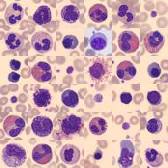

In [52]:
# load the data
blood_train_dataset = Blood_Dataclass(split='train', transform=data_transforms['train'], download=download)
blood_val_dataset = Blood_Dataclass(split='val', transform=data_transforms['test'], download=download)
blood_test_dataset = Blood_Dataclass(split='test', transform=data_transforms['test'], download=download)
print(blood_test_dataset.info)

# encapsulate data into dataloader form
blood_train_loader = data.DataLoader(dataset=blood_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
blood_val_loader = data.DataLoader(dataset=blood_val_dataset, batch_size=BATCH_SIZE*2, shuffle=False)
blood_test_loader = data.DataLoader(dataset=blood_test_dataset, batch_size=BATCH_SIZE*2, shuffle=False)

print("Δείγμα εικόνων του Blood Cell Microscope dataset:")
blood_train_dataset.montage(length=6)

In [43]:
#Το .info είναι ένα dictionary με επεξηγηματικές πληροφορίες για το dataset
print("---------------------------------------------------------------------")
print("Διαθέσιμες πληροφορίες για το dataset:")
print(blood_train_dataset.info.keys())
print("Περιγραφή dataset:")
print(blood_train_dataset.info['description'])
print("Ερμηνεία labels:")
print(blood_train_dataset.info['label'])

---------------------------------------------------------------------
Διαθέσιμες πληροφορίες για το dataset:
dict_keys(['python_class', 'description', 'url', 'MD5', 'task', 'label', 'n_channels', 'n_samples', 'license'])
Περιγραφή dataset:
The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
Ερμηνεία labels:
{'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}


## Transfer Learning

Create a new model and load the weights from the drive we saved earlier

In [53]:
model2 = Net()
model2.load_state_dict(torch.load(FILENAME))
model2 = model2.cuda()

In [54]:
# define loss function and optimizer
optimizer = optim.SGD(model2.parameters(), lr=0.005, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

## Change last layer

The blood cell dataset divides images into 8 classes (as opposed to 9 that the colon dataset did) so the out_feautures of the last fully-connected layer must be changed

In [55]:
model2.fc[2].out_features=8
model2.fc

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=8, bias=True)
)

Next, we will try to train the Blood Cell dataset with and without transfer learning and see the results

## Training (with GPU & transfer learning)

In [56]:
blood_train_tl_acc=[]
blood_validation_tl_acc=[]

# 9 Epochs
for epoch in range(9):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(blood_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model2(inputs)
        labels = labels.squeeze().long()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 30 == 29:    # print every 30 mini-batches
            print(f'[{epoch + 1}, {i + 1:3d}] loss: {running_loss / 30:.3f}')
            running_loss = 0.0
    
    print(f'Learning rate used in epoch {epoch+1} =', scheduler.get_last_lr())
    scheduler.step()
    blood_train_tl_acc.append(test_loop(blood_train_loader,model2))
    blood_validation_tl_acc.append(test_loop(blood_val_loader,model2))
    print("Accuracy in train dataset = ", blood_train_tl_acc[epoch])
    print("Accuracy in validation dataset = ", blood_validation_tl_acc[epoch])

print('Finished Training')

[1,  30] loss: 1.341
[1,  60] loss: 0.460
[1,  90] loss: 0.378
Learning rate used in epoch 1 = [0.005]
Accuracy in train dataset =  0.878022243713733
Accuracy in validation dataset =  0.8892045454545455
[2,  30] loss: 0.316
[2,  60] loss: 0.309
[2,  90] loss: 0.293
Learning rate used in epoch 2 = [0.005]
Accuracy in train dataset =  0.905004835589942
Accuracy in validation dataset =  0.908685064935065
[3,  30] loss: 0.242
[3,  60] loss: 0.241
[3,  90] loss: 0.221
Learning rate used in epoch 3 = [0.0025]
Accuracy in train dataset =  0.9266969898452612
Accuracy in validation dataset =  0.9280133928571429
[4,  30] loss: 0.222
[4,  60] loss: 0.218
[4,  90] loss: 0.206
Learning rate used in epoch 4 = [0.0025]
Accuracy in train dataset =  0.9334849492263055
Accuracy in validation dataset =  0.9355215097402597
[5,  30] loss: 0.186
[5,  60] loss: 0.188
[5,  90] loss: 0.184
Learning rate used in epoch 5 = [0.00125]
Accuracy in train dataset =  0.9380560928433268
Accuracy in validation dataset =

## Testing

In [57]:
blood_test_tl_acc = test_loop(blood_test_loader, model2)
print("Model's accuracy in Blood Cell test dataset (with transfer learning) ", blood_test_tl_acc)

Model's accuracy in Blood Cell test dataset (with transfer learning)  0.9441934283794163


## Without Transfer Learning

In [59]:
model3 = Net()
model3 = model3.cuda()

In [60]:
# define loss function and optimizer
optimizer = optim.SGD(model3.parameters(), lr=0.005, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [61]:
model3.fc[2].out_features=8
model3.fc

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=8, bias=True)
)

In [62]:
blood_train_acc=[]
blood_validation_acc=[]

# 9 Epochs
for epoch in range(9):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(blood_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model3(inputs)
        labels = labels.squeeze().long()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 30 == 29:    # print every 30 mini-batches
            print(f'[{epoch + 1}, {i + 1:3d}] loss: {running_loss / 30:.3f}')
            running_loss = 0.0
    
    print(f'Learning rate used in epoch {epoch+1} =', scheduler.get_last_lr())
    scheduler.step()
    blood_train_acc.append(test_loop(blood_train_loader,model3))
    blood_validation_acc.append(test_loop(blood_val_loader,model3))
    print("Accuracy in train dataset = ", blood_train_acc[epoch])
    print("Accuracy in validation dataset = ", blood_validation_acc[epoch])

print('Finished Training')

[1,  30] loss: 1.284
[1,  60] loss: 0.565
[1,  90] loss: 0.420
Learning rate used in epoch 1 = [0.005]
Accuracy in train dataset =  0.8770521034816247
Accuracy in validation dataset =  0.8758624188311688
[2,  30] loss: 0.366
[2,  60] loss: 0.326
[2,  90] loss: 0.300
Learning rate used in epoch 2 = [0.005]
Accuracy in train dataset =  0.8950042311411992
Accuracy in validation dataset =  0.8953429383116883
[3,  30] loss: 0.242
[3,  60] loss: 0.231
[3,  90] loss: 0.231
Learning rate used in epoch 3 = [0.0025]
Accuracy in train dataset =  0.925894584139265
Accuracy in validation dataset =  0.9226866883116883
[4,  30] loss: 0.206
[4,  60] loss: 0.202
[4,  90] loss: 0.197
Learning rate used in epoch 4 = [0.0025]
Accuracy in train dataset =  0.9357017649903288
Accuracy in validation dataset =  0.9255275974025974
[5,  30] loss: 0.163
[5,  60] loss: 0.161
[5,  90] loss: 0.162
Learning rate used in epoch 5 = [0.00125]
Accuracy in train dataset =  0.9515761000967118
Accuracy in validation dataset

## Testing

In [63]:
blood_test_acc = test_loop(blood_test_loader, model3)
print("Model's accuracy in Blood Cell test dataset (w/o transfer learning) = ", blood_test_acc)

Model's accuracy in Blood Cell test dataset (w/o transfer learning) =  0.945447508640553


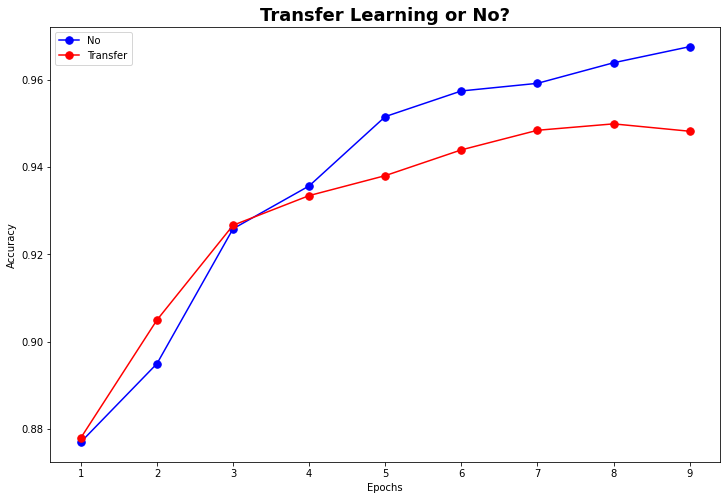

In [64]:
plt.figure(figsize=(12,8))

plt.title('Transfer Learning or No?', fontdict={'fontweight':'bold', 'fontsize': 18})

epochs=[i for i in range(1,10)]

plt.plot(epochs, blood_train_acc, 'b.-', label='No', markersize=15)
plt.plot(epochs, blood_train_tl_acc, 'r.-', label='Transfer', markersize=15)
#plt.plot(9, test_acc, 'g.-', label='Test', markersize=15)

plt.xticks(epochs[:])

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

plt.show()

Initially the transfer model learns quicker but later the no transfer model surpasses it.